In [3]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn import svm
import os
import cv2
import torch

Importing the images

In [4]:
def load_images_with_labels(data_dir, batch_size, transform=None):
    if transform is None:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224))
        ])

    dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader
    

In [5]:
data_dir="D:\\Forchheim - Copy"
Dataloader=load_images_with_labels(data_dir,batch_size=1)

In [6]:
def extracting_the_XandY_labels(dataloader):
    # Create empty lists to store images and labels
    images, labels = [], []

    # Iterate over the dataloader
    for images_batch, labels_batch in dataloader:
        images.extend(images_batch)
        labels.extend(labels_batch)

    return images, labels

In [7]:
X,y=extracting_the_XandY_labels(Dataloader)

In [8]:
len(X),len(y)

(1440, 1440)

In [9]:
y[0],y[-1]

(tensor(0), tensor(9))

In [10]:
print(f"{type(X[1])},,,,,{X[1].shape},,,,,,{X[1]},,,,,,{X[1].dim}")

<class 'torch.Tensor'>,,,,,torch.Size([3, 224, 224]),,,,,,tensor([[[0.2745, 0.2741, 0.2726,  ..., 0.0183, 0.0191, 0.0613],
         [0.2745, 0.2754, 0.2789,  ..., 0.0369, 0.0439, 0.0940],
         [0.2785, 0.2791, 0.2811,  ..., 0.0464, 0.0657, 0.0835],
         ...,
         [0.3690, 0.3589, 0.3579,  ..., 0.0315, 0.0376, 0.0569],
         [0.3599, 0.3550, 0.3601,  ..., 0.0362, 0.0356, 0.0567],
         [0.3577, 0.3607, 0.3685,  ..., 0.0333, 0.0375, 0.0578]],

        [[0.3882, 0.3878, 0.3863,  ..., 0.0172, 0.0130, 0.0486],
         [0.3882, 0.3891, 0.3926,  ..., 0.0375, 0.0397, 0.0830],
         [0.3923, 0.3928, 0.3949,  ..., 0.0493, 0.0637, 0.0748],
         ...,
         [0.3651, 0.3550, 0.3540,  ..., 0.0354, 0.0419, 0.0640],
         [0.3559, 0.3511, 0.3562,  ..., 0.0401, 0.0399, 0.0639],
         [0.3538, 0.3552, 0.3595,  ..., 0.0356, 0.0410, 0.0594]],

        [[0.6157, 0.6153, 0.6137,  ..., 0.0095, 0.0020, 0.0226],
         [0.6157, 0.6166, 0.6200,  ..., 0.0219, 0.0136, 0.0392],


In [11]:
dataloader_dictionary=Dataloader.dataset.class_to_idx
dataloader_dictionary

{'D01_Motorola_E3_1': 0,
 'D02_LG_OptimusL50_1': 1,
 'D03_Wiko_Lenny2_1': 2,
 'D04_LG_G3_1': 3,
 'D05_Apple_iPhone6s_1': 4,
 'D06_LG_G6_1': 5,
 'D07_Motorola_Z2Play_1': 6,
 'D08_Motorola_G8Plus_1': 7,
 'D09_Samsung_GalaxyS4mini_1': 8,
 'D10_Samsung_GalaxyJ1_1': 9}

Visualizing and extracting the data points of the color channels

In [24]:
def plot_color_histograms_combined(dataloader, class_dict):
    """Plots histograms for Red, Green, and Blue channels of the first image of each class in one graph per channel.

    Args:
        dataloader: PyTorch DataLoader object containing image tensors and labels.
        class_dict: Dictionary mapping class names to label indices.
    """
    processed_classes = set()
    index_to_class = {v: k for k, v in class_dict.items()}
    
    hist_r_list = []
    hist_g_list = []
    hist_b_list = []

    try:
        for images, labels in dataloader:
            # Ensure images are in the correct format
            if images.ndimension() != 4 or images.size(1) != 3:
                print(f"Unexpected image dimensions: {images.size()}")
                return

            # Iterate over the batch
            for img_tensor, label in zip(images, labels):
                class_index = label.item()
                if class_index not in processed_classes:
                    processed_classes.add(class_index)
                    
                    # Convert tensor to numpy array and scale to [0, 255]
                    img = img_tensor.numpy().transpose((1, 2, 0))
                    img = (img * 255).astype(np.uint8)

                    # Split into color channels
                    r, g, b = cv2.split(img)

                    # Calculate histograms
                    hist_r = cv2.calcHist([r], [0], None, [256], [0, 256]).flatten()
                    hist_g = cv2.calcHist([g], [0], None, [256], [0, 256]).flatten()
                    hist_b = cv2.calcHist([b], [0], None, [256], [0, 256]).flatten()

                    # Add histograms to lists
                    hist_r_list.append((hist_r, index_to_class[class_index]))
                    hist_g_list.append((hist_g, index_to_class[class_index]))
                    hist_b_list.append((hist_b, index_to_class[class_index]))

                    # Stop processing if all classes have been covered
                    if len(processed_classes) == len(class_dict):
                        break

        # Plot all histograms
        plt.figure(figsize=(15, 5))
        for hist, label in hist_r_list:
            plt.plot(hist, label=label)
        plt.xlabel('Intensity')
        plt.ylabel('Count')
        plt.title('Red Channel Histogram')
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(15, 5))
        for hist, label in hist_g_list:
            plt.plot(hist, label=label)
        plt.xlabel('Intensity')
        plt.ylabel('Count')
        plt.title('Green Channel Histogram')
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(15, 5))
        for hist, label in hist_b_list:
            plt.plot(hist, label=label)
        plt.xlabel('Intensity')
        plt.ylabel('Count')
        plt.title('Blue Channel Histogram')
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing images: {e}")

    return hist_r_list,hist_g_list,hist_b_list


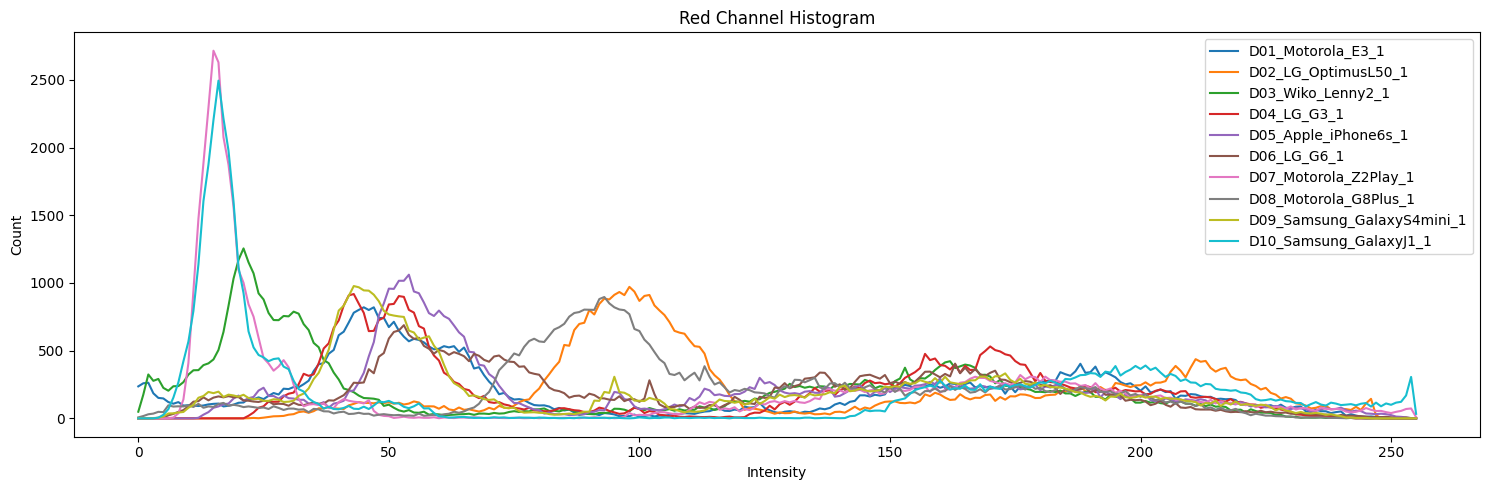

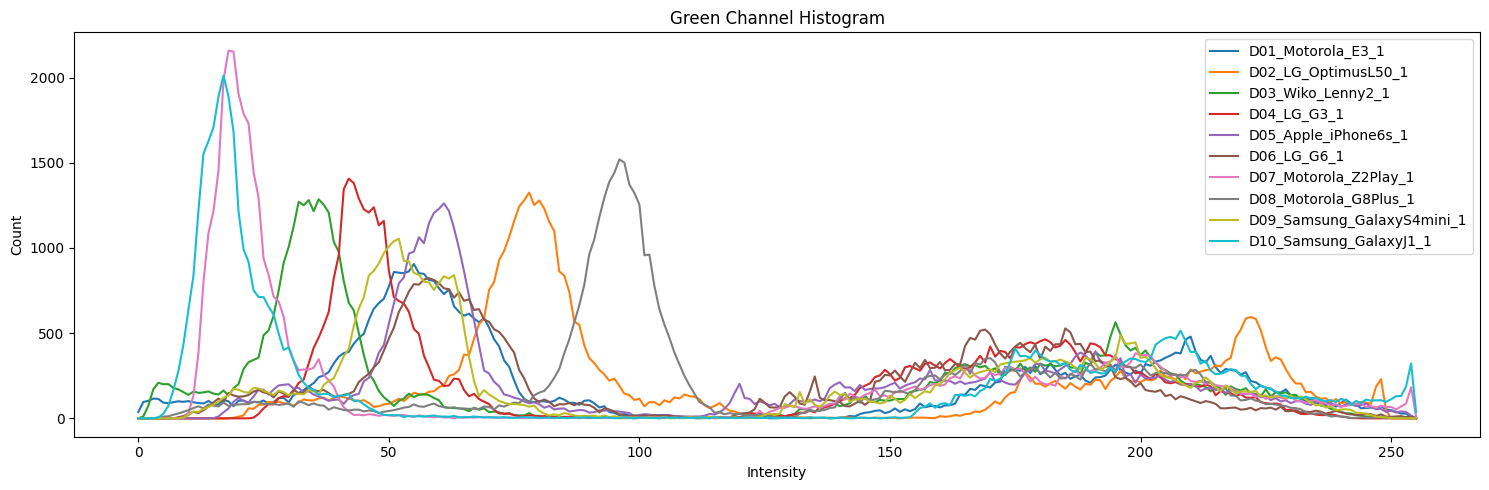

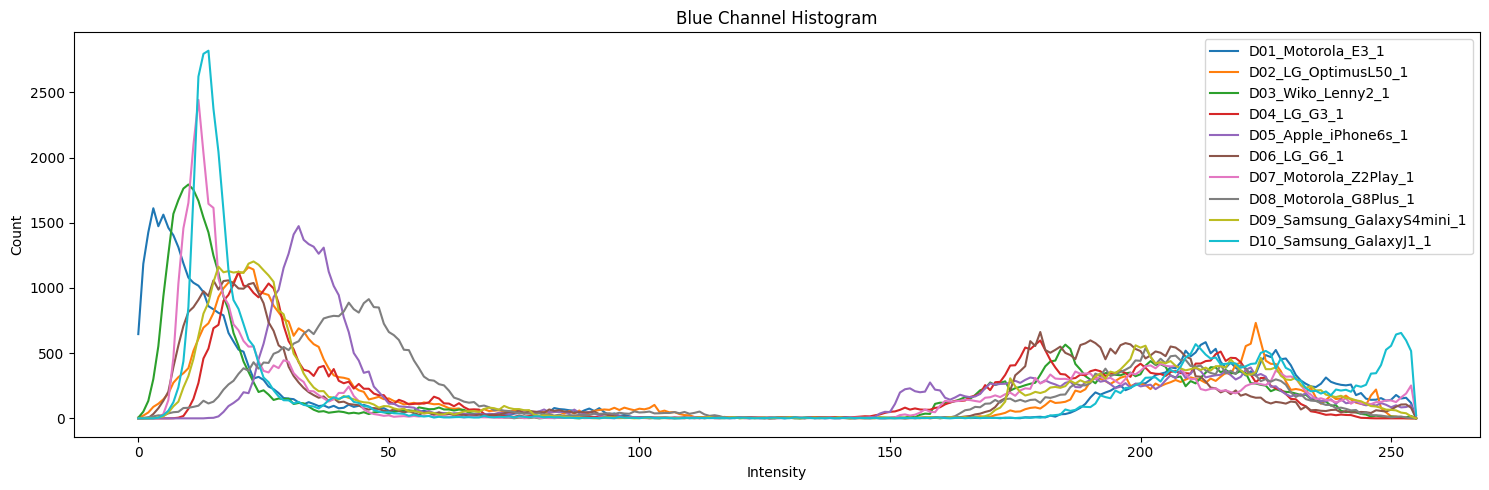

In [25]:
list_red_channel,list_green_channel,list_blue_channel= plot_color_histograms_combined(Dataloader,dataloader_dictionary)

In [17]:
list_red_channel,len(list_red_channel),type(list_red_channel)

([(array([236., 259., 263., 185., 151., 147., 120., 108., 120.,  94.,  97.,
           94.,  91.,  95., 103., 107., 109.,  88.,  93., 101., 115., 117.,
          144., 141., 155., 142., 166., 187., 176., 219., 216., 231., 230.,
          252., 278., 349., 399., 408., 477., 505., 614., 640., 708., 780.,
          801., 820., 800., 820., 740., 742., 674., 713., 647., 603., 569.,
          587., 579., 561., 531., 510., 514., 533., 524., 533., 491., 523.,
          456., 368., 378., 319., 271., 235., 178., 188., 156., 139., 142.,
          135., 114.,  98.,  95.,  96.,  87.,  67.,  77.,  58.,  65.,  43.,
           50.,  36.,  37.,  33.,  24.,  39.,  35.,  29.,  16.,  18.,  16.,
           28.,  12.,  17.,  23.,  14.,  20.,  18.,  26.,  34.,  32.,  38.,
           36.,  33.,  43.,  50.,  53.,  66.,  73.,  56.,  54.,  65.,  58.,
           86.,  79.,  83., 114.,  76.,  59.,  46.,  38.,  49.,  53.,  48.,
           39.,  49.,  46.,  58.,  73.,  67.,  77., 102., 114.,  99., 122.,
          12

In [21]:
list_red_channel[1][1],type(list_red_channel[1][1])

('D02_LG_OptimusL50_1', str)